# Лабораторная работа №1.

Выполнил: студент гр. 9383 Моисейченко Кирилл. Вариант: №11.

## Цель работы:

Изучить возможности библиотек Python для решения цифровой обработки сигналов.

## Задание:

1. Выполнить загрузку аудио сигнала и построить огибающую (график).
2. Фильтрация (выбрать один из 4-х основных типо фильтров). Получить фильтрованный сигнал.
3. Детектор сигнал/шум. Получчить сигнал после детектирования.
4. Эффект "Эхо". Получить сигнал после работы аудио-эффекта.
5. *Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.

## Выполнение работы:

### 1. Загрузка аудио сигнала и построение огибающей графика.

In [49]:
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

In [50]:
sound_rate, sound = wavfile.read('03-01-05-01-02-01-11_A11.wav')

Имеется сигнал $x(i), i \in [0,N-1].$ Хотим построить огибающую $y(j), j \in [0, n-1].$ Пусть $m = [\frac{N}{n}] -$ число точек в интервале усреднения. Тогда $y(i) = \frac{1}{m}\displaystyle\sum_{k=mj}^{mj + m -1} |x(k)|$

In [51]:
sound_time = sound.size / sound_rate
n = 500
m = sound.size // n
x = np.linspace(0, sound_time, sound.size)
x_curve = np.linspace(0, sound_time, n)
y_curve = np.zeros(n)
for i in range(n):
    temp_sum = 0
    for j in range (m * i, m * i + m - 1):
         temp_sum += abs(sound[j])
    y_curve[i] = temp_sum / m

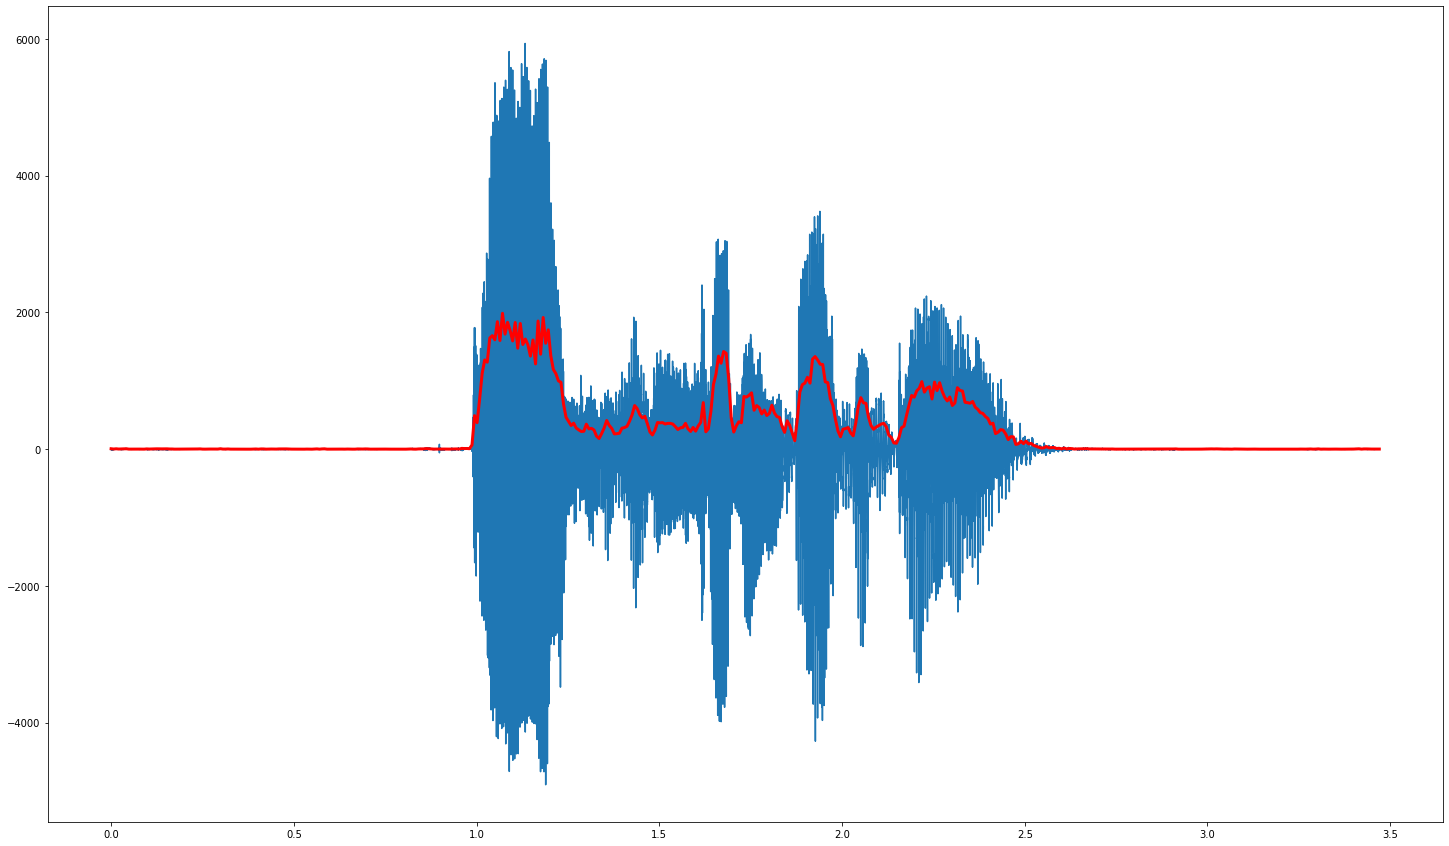

In [52]:
plt.rcParams["figure.figsize"]=25, 15
plt.plot(x, sound)
plt.plot(x_curve, y_curve, linewidth = 3, color = "red")
plt.show()

## 2. Фильтрация сигнала.

Был выбран фильтр нижних частот.
$F_d - $ частота дискретизации, $F_s - $ частота среза, $m - $ порядок фильтра. Требуется вычислить $wn = 2\frac{F_s}{F_d}$

In [53]:
F_s = 500
m = 1
wn = 2 * F_s / sound_rate 
b, a = signal.butter(m, wn, "lowpass")
filtered_sound = signal.filtfilt(b,a,sound)
wavfile.write("filtered_sound.wav", sound_rate, filtered_sound.astype(np.int16))

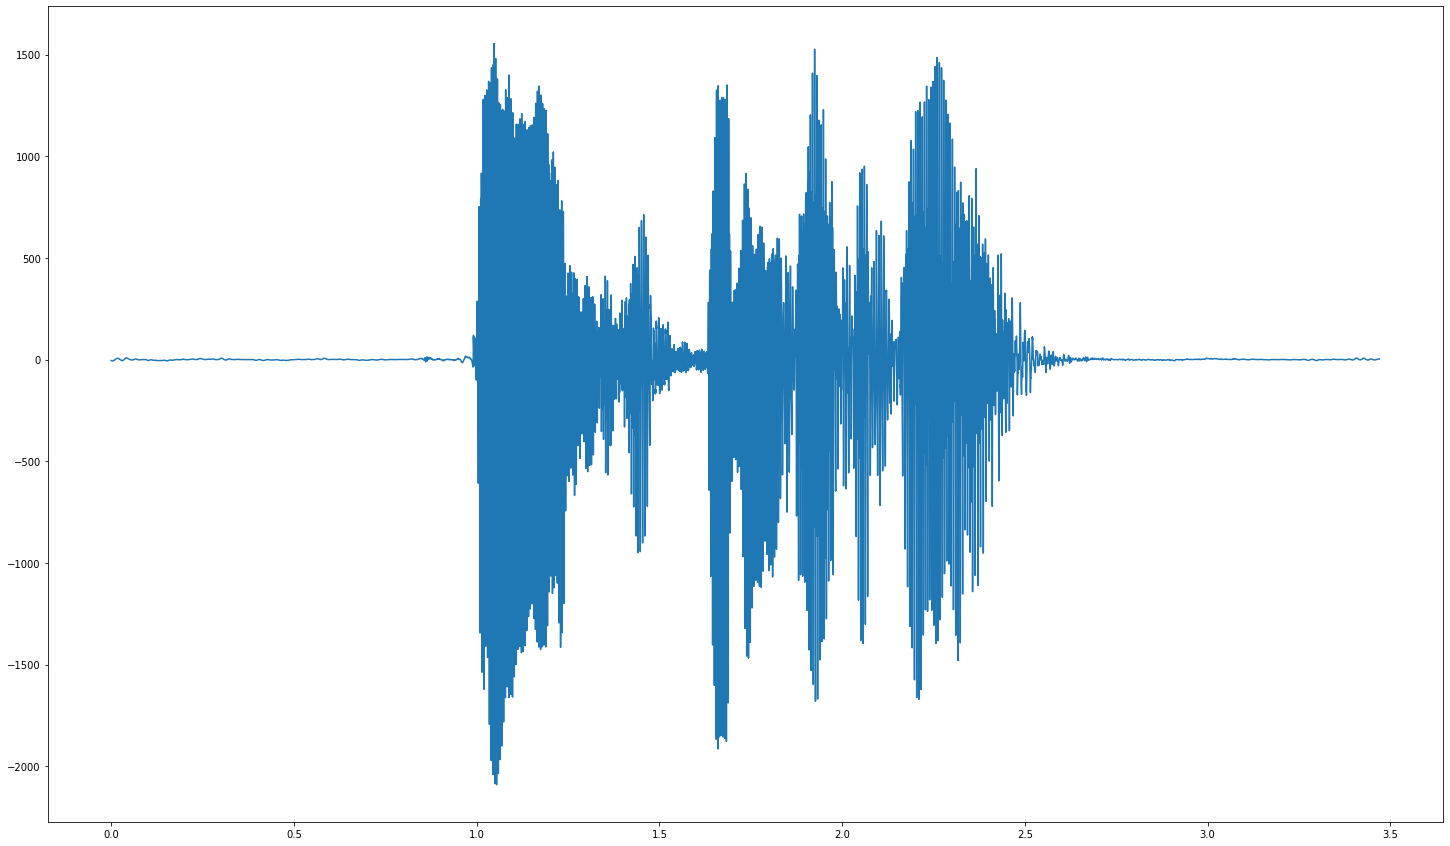

In [54]:
plt.rcParams["figure.figsize"]=25, 15
plt.plot(x, filtered_sound)
plt.show()

## 3. Детектор сигнал/шум.

Определяем среднее сигнала по амплитуде (без учёта знака): $mid = \frac{1}{N} \displaystyle\sum_{k=0}^{N-1} |x(k)| ~$.

Определяем порог детектора $ Th = \alpha \cdot mid$ , где $ 0<\alpha<1$ подбирается экспериментально. Задаём величину "провала" (в отсчётах) $k$. Обозначим $y(i)$ сигнал после детектирования.
1. Событие "начало" сигнала. Если $x(i)$ в течении $k$ отсчётов превышает порог, $y(i) = x(i) $.
2. Событие "окончание сигнала". Если $x(i)$ в течении $k$ отсчётов меньше порога, $y(i) = 0$

In [55]:
sum = 0
for i in range(sound.size):
    sum += abs(sound[i])
mid = sum / sound.size
a = 0.5
Th = a * mid
k = 10
signal_c = 0
not_signal_c = 0
isSignal = False
detected_sound = np.zeros(sound.size)
for i in range(sound.size):
    if abs(sound[i]) > Th:
        signal_c += 1
        if signal_c >= k: 
            signal_c = k
            isSignal = True
            detected_sound[i] = sound[i]
        continue
    if not isSignal:
        signal_c = 0
        continue
    if isSignal:
        signal_c -= 1
        if signal_c <= 0: 
            isSignal = False
        else: 
            detected_sound[i] = sound[i]

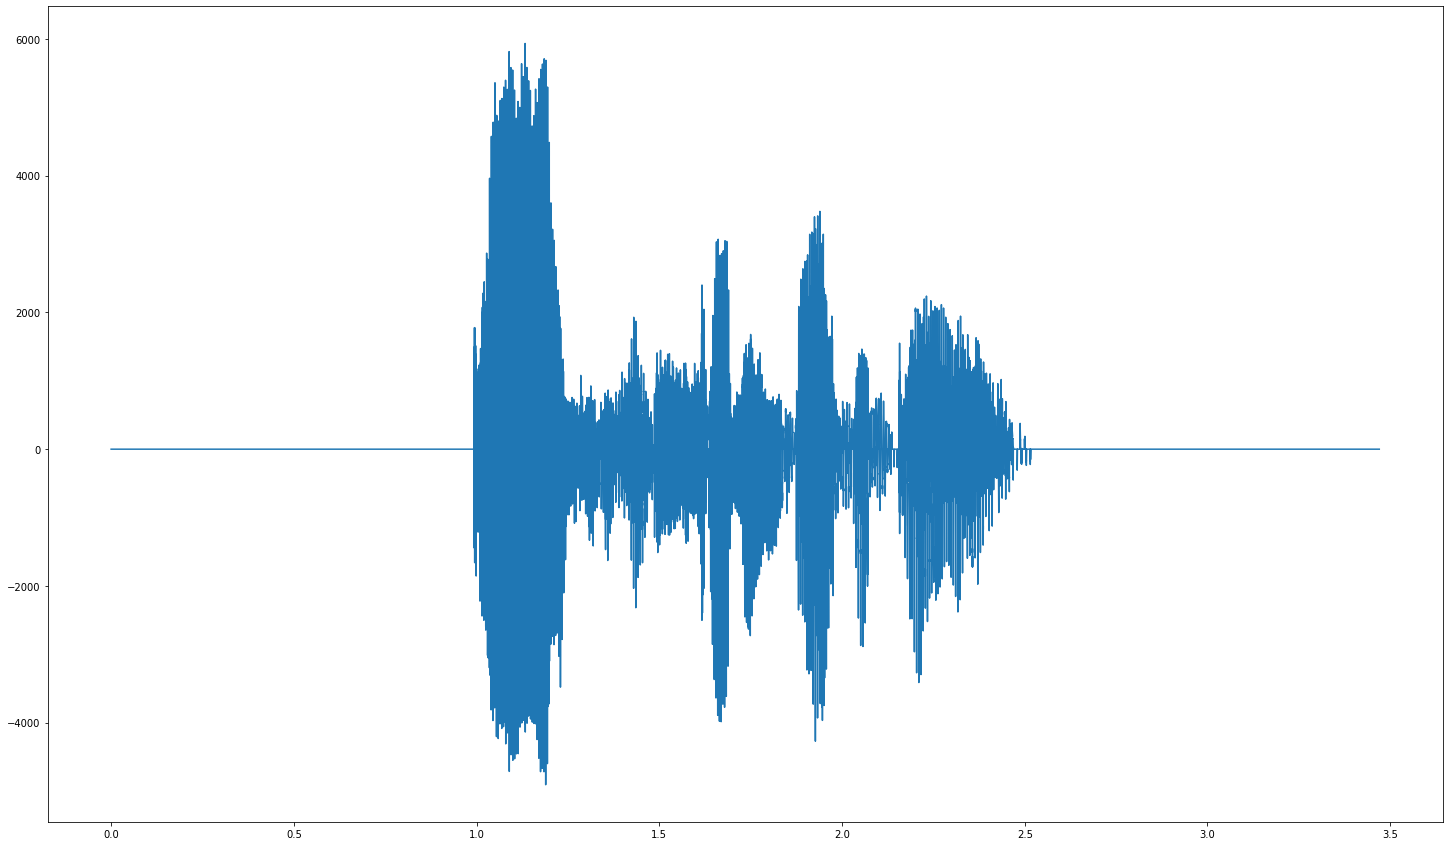

In [56]:
plt.rcParams["figure.figsize"]=25, 15
plt.plot(x, detected_sound)
plt.show()
wavfile.write("detected_sound.wav", sound_rate, detected_sound.astype(np.int16))

## 4. Эффект "Эхо"

Ревербератор состоит из 8 линий задержки. Каждая линия задержки имеет свой весовой коэффициент. Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка. Соотношение между начальным и обработанным сигналом задается коэффициентом применимости $\gamma=0.9$. 

Значения задержек: $D_i = D_1 * 2^{(1-i)/N_L}, i = 2,...,8$. $D_1$ - максимальная задержка в секундах(задается пользователем).

Весовые коэффициенты при линиях задержек: $\alpha_i = 1 - \frac{i}{10}, i = 1,...,8$

In [57]:
Di = np.zeros(8)
gamma = 0.9
max = float(input("Введите максимальную задержку(в секундах): "))
Di[0] = max
for i in range(1, 8):
    Di[i] = max * (2 ** ((-i)/8))
alpha = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
all_samples = []
for i in range(8):
    new_sound = alpha[i] * sound 
    all_samples.append(new_sound)
Fs = 900
wn = 2 * Fs / sound_rate
m = 1
b, a = signal.butter(m, wn, "lowpass")
for i in range(8):
    all_samples[i] = signal.filtfilt(b, a, all_samples[i])
    all_samples[i] = all_samples[i] * gamma
echo_sound = np.zeros(int((np.sum(Di) + len(sound) / sound_rate + 1) * sound_rate))
for i in range(8):
    if i >= 1:
        Di[i] += Di[i-1]
    for j in range(len(all_samples[i])):
        echo_sound[j + int(Di[i] * sound_rate)] += all_samples[i][j]
for i in range(len(sound)):
    echo_sound[i] += sound[i]
wavfile.write("echo_sound.wav", sound_rate, echo_sound.astype(np.int16))

Введите максимальную задержку(в секундах): 1.5


## 5*. Эффект "Distortion"

Обозначим входной и выходной сигналы, соотвественно как $x(i)$ и $y(i), i \in [0,N-1]$

Пользователь задаёт порог $Th$ и максимальное значение сигнала $max > Th$. Тогда:

$Y(i) =
  \begin{cases}
    x(i)       & \quad \text{if } Th \\
    max \cdot sign(x(i))  & \quad \text{if  }  |x(i)| > Th
  \end{cases}$

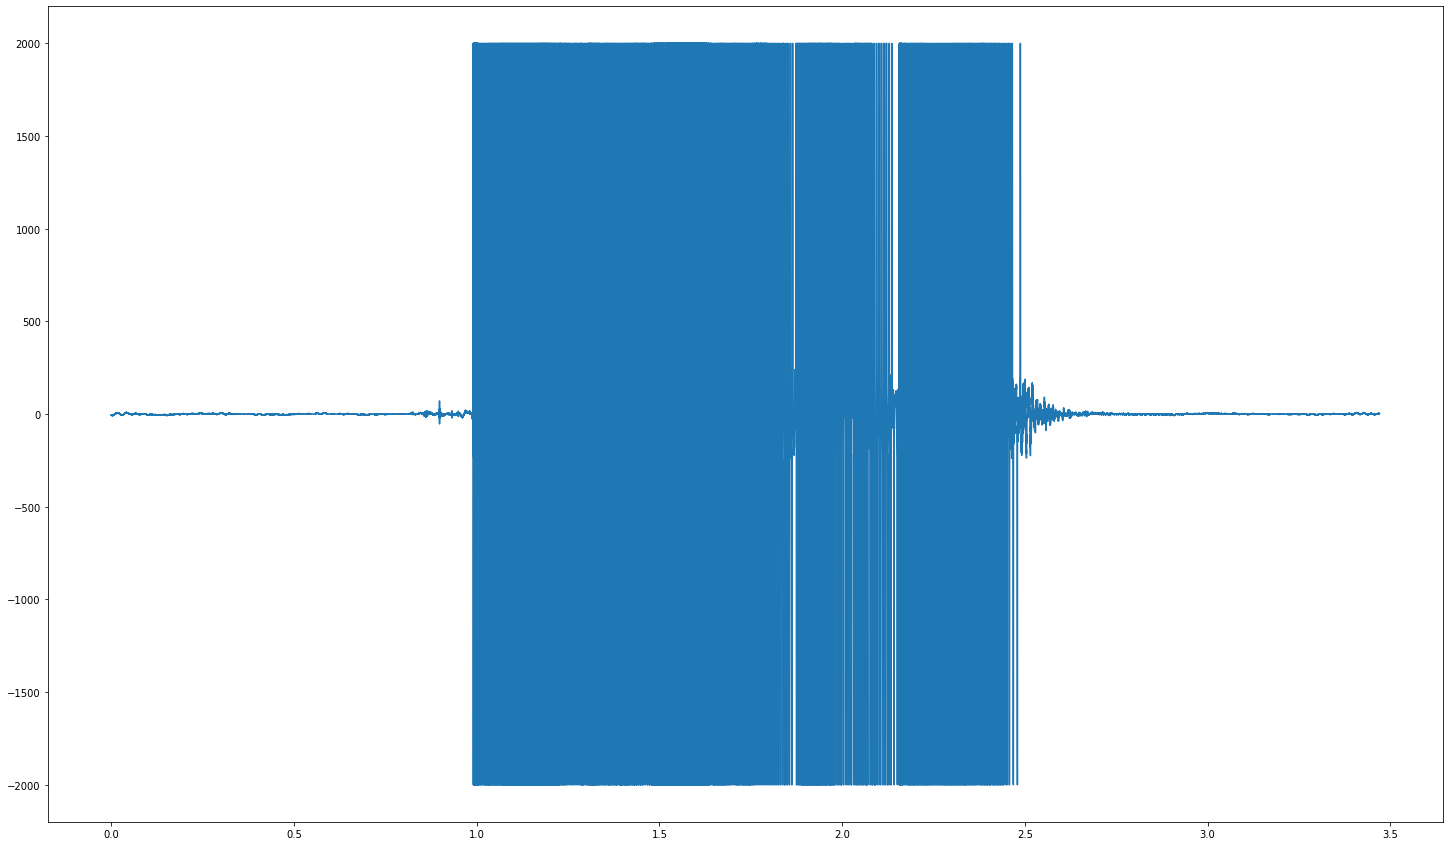

In [58]:
Th = 250
max = 2000
distortion_sound = np.zeros(sound.size)
for i in range(sound.size):
    if (abs(sound[i]) < Th):
        distortion_sound[i] = sound[i]
    else:
        distortion_sound[i] = max * np.sign(sound[i])
        
plt.rcParams["figure.figsize"]=25, 15
plt.plot(x, distortion_sound)
plt.show()
wavfile.write("distortion_sound.wav", sound_rate, distortion_sound.astype(np.int16))

## Вывод

В ходе выполнения лабораторной работы были изучены возможности библиотек Python для решение задач цифровой обработки сигналов.